In [1]:
import dask
from dask.distributed import Client, LocalCluster
import xarray as xr
import numpy as np
import  matplotlib.pyplot as plt
import os
from ipywidgets import Image
from ipywidgets import ColorPicker, IntSlider, link, AppLayout, HBox
from ipycanvas import  hold_canvas,  MultiCanvas #RoughCanvas,Canvas,
import imageio

In [2]:
# local cluster on current machine
tempfolder = '/mnt/nas_Uwrite/fische_r/tmp'
dask.config.config['temporary-directory'] = tempfolder

cluster = LocalCluster(dashboard_address=':35154' ) 
client = Client(cluster)
print('Dashboard at '+cluster.dashboard_link)

2022-09-16 14:49:16,937 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/nas_Uwrite/fische_r/tmp/dask-worker-space/worker-sghnqac6', purging
2022-09-16 14:49:16,945 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/nas_Uwrite/fische_r/tmp/dask-worker-space/worker-thtnnph0', purging
2022-09-16 14:49:16,952 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/nas_Uwrite/fische_r/tmp/dask-worker-space/worker-gxu6ebw8', purging
2022-09-16 14:49:16,959 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/nas_Uwrite/fische_r/tmp/dask-worker-space/worker-lt5i3pve', purging
2022-09-16 14:49:16,965 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/nas_Uwrite/fische_r/tmp/dask-worker-space/worker-i9td0s3h', purging
2022-09-16 14:49:16,970 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/nas_Uwrite/fische_r/tmp/dask-worker-space/worker-pug1j1vz', purgin

Dashboard at http://127.0.0.1:35154/status


In [3]:
# # home-made cluster
# scheduler_address = "129.129.188.248:8786"
# client = Client(scheduler_address)
# print('Dashboard at '+client.dashboard_link)

In [4]:
from filter_functions import image_filter

In [5]:
import training_functions as tfs
from training_functions import train_segmentation


In [6]:
def on_mouse_down(x, y):
    global drawing
    global position
    global shape
    drawing = True
    position = (x, y)
    shape = [position]

def on_mouse_move(x, y):
    global drawing
    global position
    global shape
    if not drawing:
        return
    with hold_canvas():
        canvas.stroke_line(position[0], position[1], x, y)
        position = (x, y)
    shape.append(position)

def on_mouse_up(x, y):
    global drawing
    global positiondu
    global shape
    drawing = False
    with hold_canvas():
        canvas.stroke_line(position[0], position[1], x, y)
        canvas.fill_polygon(shape)
    shape = []

In [7]:
path = '/home/fische_r/NAS/testing/Jeremy_tomo/tomodata.nc'
featpath = '/home/fische_r/NAS/testing/Jeremy_tomo/featdata.nc'
# path = r"C:\Zwischenlager\tomodata.nc"
# path = '/mpc/homes/fische_r/wood3/wood_tomo.nc'
# featpath = '/mpc/homes/fische_r/wood3/featdata.nc'

path = '/home/fische_r/NAS/testing/TIM_tomo/tomodata.nc'
featpath = '/home/fische_r/NAS/testing/TIM_tomo/featdata.nc'

path = '/mpc/homes/fische_r/NAS/testing/TIM_tomo/tomodata.nc'
featpath = '/mpc/homes/fische_r/NAS/testing/TIM_tomo/featdata.nc'

In [8]:
# chunksize = (40, 35, 40, 37)
chunks = {'x': 182, 'y':15, 'z':95, 'time':32}
# chunks = 'auto'

In [9]:
IF = image_filter(data_path=path, outpath = featpath, chunksize = chunks)

In [10]:
# IF.open_raw_data()

In [11]:
IF.open_lazy_data(chunks='auto')

/mpc/homes/fische_r/miniconda3/lib/python3.9/site-packages/dask/array/core.py:3423: UserWarning: Passing an object to dask.array.from_array which is already a Dask collection. This can lead to unexpected behavior.
  warnings.warn(


In [12]:
# IF.data = IF.data[30:-20,15:-50,:100,:50] #cropping for wood

In [13]:
IF.data

,Array,Chunk
Bytes,123.55 GiB,126.64 MiB
Shape,"(1861, 169, 1140, 185)","(364, 30, 190, 32)"
Count,1297 Tasks,1296 Chunks
Type,uint16,xarray.core.dataarray.DataArray


In [14]:
# IF.data = IF.data[500:1000,:,:500,:140] #test croppping for Tim's data


In [15]:
# define new chunks based on auto-suggestion
# smaller chunks could help with many cpu, maybe xeperiminet a bit
# however, lazy looading seems super slow for custom chunks, maybe multiples of auto
# chunks = {'x': 182, 'y':15, 'z':95, 'time':32}

In [16]:
# IF.data = IF.data.rechunk('auto')

In [17]:
# dataset = xr.open_dataset(path)
# data = dataset['tomo'][500:1000,:,:500,:140].data

In [18]:
# shp = data.shape
# coords = {'x': np.arange(shp[0]), 'y': np.arange(shp[1]), 'z': np.arange(shp[2]), 'time': np.arange(shp[3])}
# cropped_DS = xr.Dataset({'tomo': (['x','y','z','time'], data)},
#                          coords = coords
#                          )
# path = '/mpc/homes/fische_r/NAS/testing/TIM_tomo/tomodata_crop.nc'
# cropped_DS.to_netcdf(path)

In [19]:
IF.prepare()

ValueError: operands could not be broadcast together with shapes (1861, 169, 1140, 185) (185, 1861, 169, 1140)

In [20]:
IF.stack_features()

In [21]:
IF.feature_stack

,Array,Chunk
Bytes,28.96 TiB,506.54 MiB
Shape,"(1861, 169, 1140, 185, 60)","(364, 30, 190, 32, 1)"
Count,1627313 Tasks,77760 Chunks
Type,float64,numpy.ndarray


In [22]:
# IF.compute() #not sure what is more efficient, but I would compute the features and even store them on disk
# had the impression that otherwise many redundant operations happen, seems ok for really large datasets. so no idea ...

In [23]:
IF.make_xarray_nc()

In [24]:
# IF.make_xarray_nc(store=True)

In [25]:
# training_path = r"C:\Zwischenlager\Jeremy_tomo"
training_path = '/home/fische_r/NAS/testing/Jeremy_tomo'
training_path = '/mpc/homes/fische_r/wood3/'
training_path = '/mpc/homes/fische_r/NAS/testing/TIM_tomo'#/cropped'
if not os.path.exists(training_path):
    os.mkdir(training_path)

In [26]:
TS = train_segmentation(training_path=training_path)

In [27]:
TS.import_lazy_feature_data(IF.result, IF.original_dataset)

In [28]:
# TS.import_feature_data(IF.result)

### iterative training (even if you have a training set, do not skip here)

In [29]:
# re-training for lazy data super slow, better use the the coordinates of this list and run the cells here for now
os.listdir(os.path.join(training_path, 'label_images'))

['label_image_y_140_time_45_.tif',
 'label_image_y_110_time_120_.tif',
 'label_image_y_120_time_0_.tif',
 'label_image_y_140_time_50_.tif',
 'label_image_y_160_time_120_.tif',
 'label_image_y_150_time_0_.tif',
 'label_image_y_84_time_170_.tif',
 'label_image_y_120_time_80_.tif',
 'label_image_y_140_time_120_.tif',
 'label_image_y_150_time_170_.tif',
 'label_image_y_140_time_55_.tif',
 'label_image_y_110_time_0_.tif',
 'label_image_y_110_time_70_.tif']

In [30]:
TS.suggest_training_set()

You could try  z = 1026  and  y = 12
However, please sort it like the original xyztime


In [31]:
c1 = 'y'
p1 = 110
c2 = 'time'
p2 = 0

In [32]:
TS.load_training_set(c1, p1, c2, p2)

TypeError: 'DataArray' object is not callable

In [65]:
alpha = 0.15
im8 = TS.current_im8
resultim = TS.current_result
width = im8.shape[1]
height = im8.shape[0]
Mcanvas = MultiCanvas(4, width=width, height=height)
background = Mcanvas[0]
resultdisplay = Mcanvas[2]
truthdisplay = Mcanvas[1]
canvas = Mcanvas[3]
canvas.sync_image_data = True
drawing = False
position = None
shape = []
image_data = np.stack((im8, im8, im8), axis=2)
background.put_image_data(image_data, 0, 0)
resultdisplay.global_alpha = alpha
if np.any(resultim>0):
    result_data = np.stack((255*(resultim==0), 255*(resultim==1), 255*(resultim==2)), axis=2)
else:
    result_data = np.stack((0*resultim, 0*resultim, 0*resultim), axis=2)
resultdisplay.put_image_data(result_data, 0, 0)
canvas.on_mouse_down(on_mouse_down)
canvas.on_mouse_move(on_mouse_move)
canvas.on_mouse_up(on_mouse_up)
picker = ColorPicker(description="Color:", value="#ff0000")
slidealpha = IntSlider(description="Result overlay", value=0.15)
link((picker, "value"), (canvas, "stroke_style"))
link((picker, "value"), (canvas, "fill_style"))
HBox((Mcanvas, picker, slidealpha))

In [50]:
# tfs.plot_im_histogram(TS.current_im8)
# TS.current_im8 = tfs.adjust_image_contrast(TS.current_im8, 110,160)

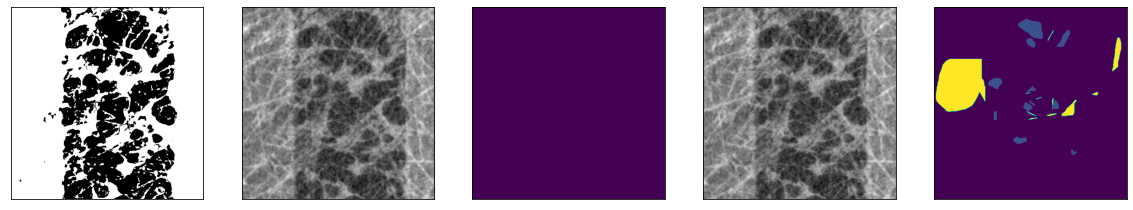

In [61]:
fig, axes = plt.subplots(1,5, figsize=(20,10))
axes[0].imshow(TS.current_result, 'gray')
axes[1].imshow(TS.current_im8, 'gray')

# TS.current_diff_im = TS.current_im-TS.current_first_im
# TS.current_diff_im = TS.current_diff_im/TS.current_diff_im.max()*255
axes[2].imshow(-TS.current_diff_im)
# axes[3].imshow(m8old, 'gray')
axes[3].imshow(TS.current_first_im, 'gray')
axes[4].imshow(TS.current_truth)

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

In [57]:
label_set = canvas.get_image_data()

TS.current_truth[label_set[:,:,0]>0] = 1
TS.current_truth[label_set[:,:,1]>0] = 2
TS.current_truth[label_set[:,:,2]>0] = 4

imageio.imsave(TS.current_truthpath, TS.current_truth)

In [58]:
TS.train_slice()

training and classifying


In [59]:
# import pickle
# pickle.dump(TS.current_feat_stack, open(os.path.join(training_path,'y110t0.p'),'wb'))

/tmp/ipykernel_1643847/3278944968.py:2: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(TS.feature_names, TS.clf.feature_importances_,'x')


Text(0, 0.5, 'importance')

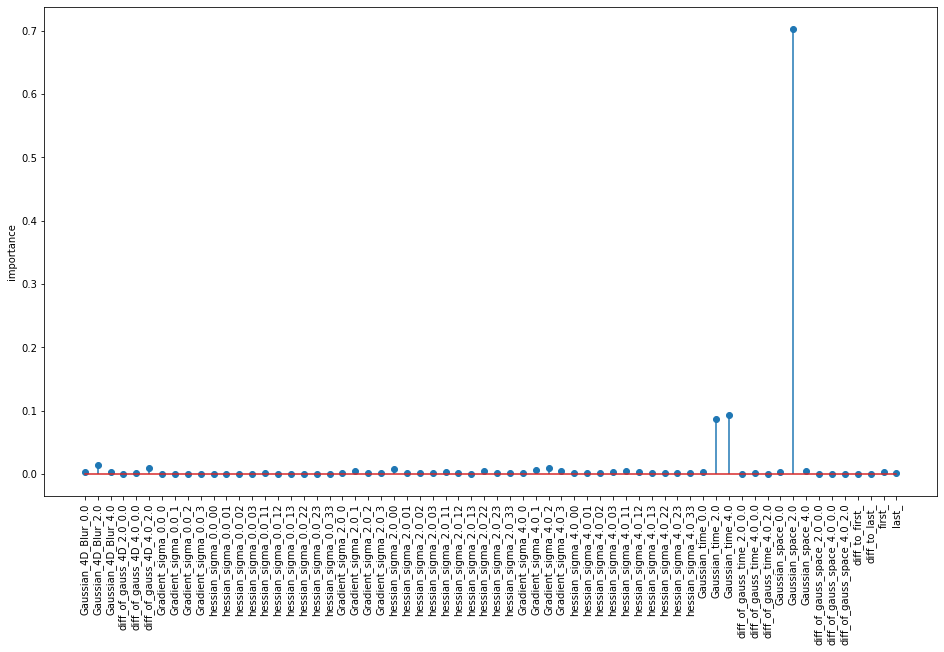

In [60]:
plt.figure(figsize=(16,9))
plt.stem(TS.feature_names, TS.clf.feature_importances_,'x')
plt.xticks(rotation=90)
plt.ylabel('importance') 

In [270]:
TS.current_im.shape

(1861, 1140)

In [271]:
TS.feat_data

,Array,Chunk
Bytes,36.20 TiB,506.54 MiB
Shape,"(1861, 169, 1140, 185, 75)","(364, 30, 190, 32, 1)"
Count,1946785 Tasks,97200 Chunks
Type,float64,numpy.ndarray


In [251]:
# TS.current_im8 = tfs.adjust_image_contrast(TS.current_im8, 50,200)

### when done, maybe save the classifier

In [706]:
# TS.pickle_classifier()

### use an existing trainingset to train classifier (adhere to label iamge naming convention)

In [37]:
#retraining somehow very slow with lazy data
TS.train()

2022-09-12 17:01:34,438 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 44.48 GiB -- Worker memory limit: 62.96 GiB
2022-09-12 17:01:34,538 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 44.93 GiB -- Worker memory limit: 62.96 GiB
2022-09-12 17:01:34,640 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

KilledWorker: ("('array-990aa99f48c81f9276ca105ec8aec9cd', 0, 0, 0, 0)", <WorkerState 'tcp://127.0.0.1:35109', name: 10, status: closed, memory: 0, processing: 87>)

In [26]:
# TS.pickle_classifier()

In [27]:
from segmentation import segmentation
# import pickle

In [24]:
SM = segmentation(training_path = training_path, classifier_path=os.path.join(training_path, 'classifier.p'))

In [28]:
# SM.import_classifier(TS.clf)
# SM.clf = pickle.load(open(os.path.join(training_path, 'classifier.p'), 'rb'))

In [29]:
SM.import_feature_data(IF.result)

In [39]:
# SM.lazy = False
part2 = SM.feat_data.feature_stack[:,:,:,25:,:]

In [40]:
num_feat = part2.shape[-1]
clf = SM.clf
seg2 = clf.predict(part2.data.reshape(-1,num_feat))
seg2 = seg2.reshape(part2[...,0].shape).astype(np.uint8)

In [38]:
# seg1 = seg1.reshape(part1[...,0].shape).astype(np.uint8)

In [ ]:
# SM.classify_all()

classifying ...


In [707]:
# SM.store_segmented_data()

In [49]:
seg_data.size/1024**3

0.2153683453798294

In [47]:
path = os.path.join(SM.training_path, 'segmented.nc')

#TODO: propagate labels from raw data
#TODO: if self.segmented_data is a dask array, rechunk for saving
shp = seg_data.shape
data = xr.Dataset({'segmented': (['x','y','z','time'], seg_data)},
                               coords = {'x': np.arange(shp[0]),
                               'y': np.arange(shp[1]),
                               'z': np.arange(shp[2]),
                               'time': np.arange(shp[3]),
                               'feature': SM.feature_names}
                     )
# data.to

In [50]:
data.to_netcdf(path)

In [51]:
TS.plot_importance()

NameError: name 'TS' is not defined

/tmp/ipykernel_835997/3278944968.py:2: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(TS.feature_names, TS.clf.feature_importances_,'x')


Text(0, 0.5, 'importance')

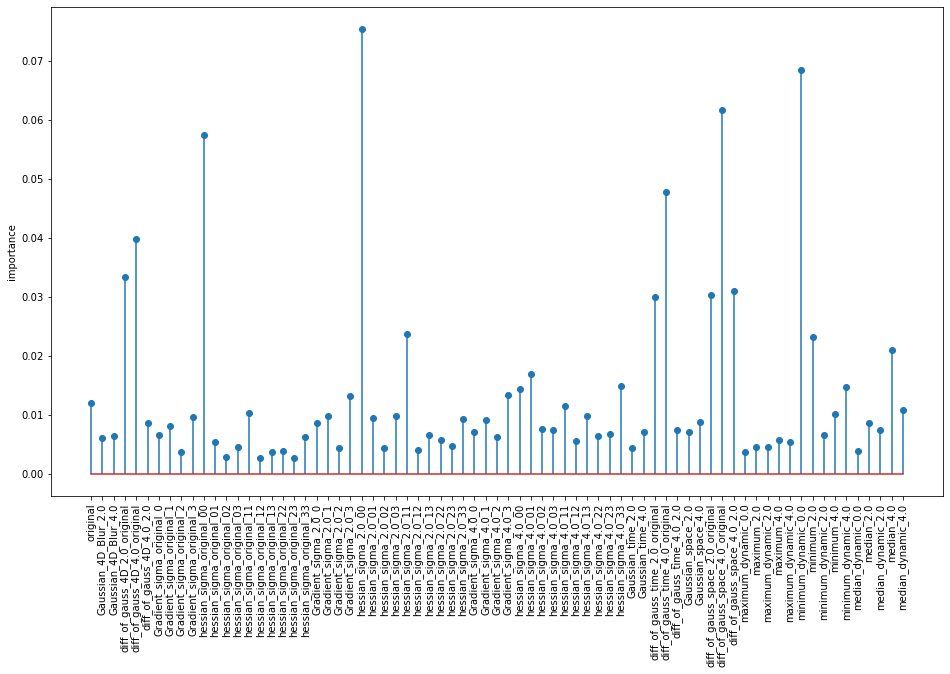

In [632]:
plt.figure(figsize=(16,9))
plt.stem(TS.feature_names, TS.clf.feature_importances_,'x')
plt.xticks(rotation=90)
plt.ylabel('importance') 

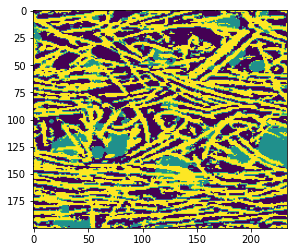

In [49]:
plt.imshow(SM.segmented_data[:,10,:,-1])

In [112]:
1

1